In [1]:
!pip install datasets -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2021.4.0 requires fsspec==2021.04.0, but you have fsspec 2021.11.0 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install sagemaker -U -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p37/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install s3fs==0.4.2 -U -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p37/bin/python -m pip install --upgrade pip' command.


### Load dataset and have a peak:

This cell is required in SageMaker Studio, otherwise the download of the dataset will throw an error.
After running this cell, the kernel needs to be restarted. After restarting tthe kernel, continue with the cell below (loading the dataset)

In [1]:
# %%capture
# import IPython
# !conda install -c conda-forge ipywidgets -y
# IPython.Application.instance().kernel.do_shutdown(True)

In [2]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset('ade_corpus_v2', 'Ade_corpus_v2_classification')
df = pd.DataFrame(dataset['train'])
df.sample(5, random_state=124)

Downloading:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/868k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset ade_corpus_v2 downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,text,label
2148,Eruptive epidermoid cysts resulting from treat...,1
8891,"Diagnosis, therapy, and complications of thera...",0
7660,This case report describes the diagnostic work...,0
7507,"During IFN therapy, serum aminotransferases fe...",0
8174,Reversal of post-reperfusion coagulopathy by p...,0


In [5]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 300,'display.max_columns',150):
              display(df.sample(10))

,text,label
7831,Patients should be informed of the risk of septic arthritis.,0
14078,"In view of her cachexia and cytopaenia, emergency chemotherapy was initiated using a modified regimen of carboplatin, etoposide and vincristine (CEO) in preference to the more traditional but less well-tolerated VAC (vincristine, actinomycin D, cyclophosphamide).",0
6016,"Less common adverse events to dapsone include the idiosyncratic reactions of leukopenia and agranulocytosis, cutaneous eruptions, peripheral neuropathy, psychosis, toxic hepatitis, cholestatic jaundice, nephrotic syndrome, renal papillary necrosis, severe hypoalbuminemia without proteinuria, an ...",1
16090,Treatment with calcitriol.,0
586,We report a case of interstitial pulmonary disease that occurred together with lymphocytic colitis during treatment with ticlopidine.,1
15148,"While she was receiving the maximum dose of 180 mg/day of cinacalcet HCl and PTH at 443 pg/mL, she needed to be hospitalized for a right hip prothesis.",0
14752,A patient receiving long-term corticosteroid therapy for asthma had two episodes of Pneumocystis carinii pneumonia (PCP) 8 years apart.,0
21319,We describe various measures to reduce severe anxiety that interfered with much-needed maintenance electroconvulsive therapy in a 32-year-old man.,0
1973,The relation between tacrolimus treatment and staining was suggested by the appearance of pigmentation during topical tacrolimus treatment and its clinical disappearance when treatment was stopped.,1
11959,There was minimum toxicity reported for either of the arms and no treatment related deaths.,0


### Determine ratio of positive ADE phrases compared to total dataset

In [6]:
df['label'].sum()/len(df)

0.29005783296478993

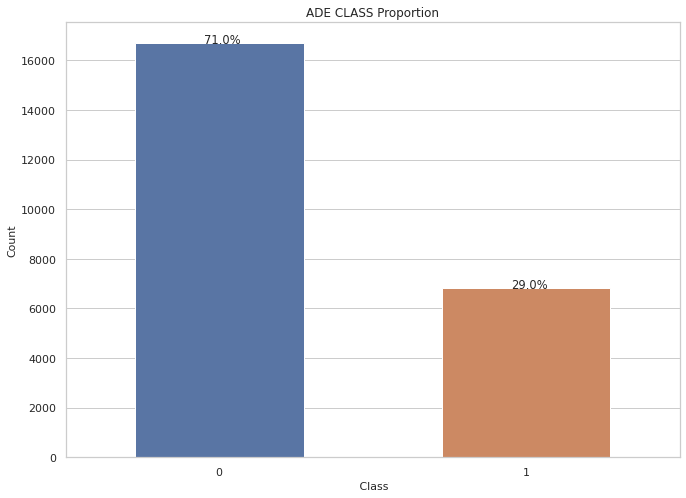

In [10]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(11,8))

color_labels = df['label'].unique()

# List of color palette to use
rgb_values = sns.color_palette("tab10", 2)

# Map label to color palette

color_map = dict(zip(color_labels, rgb_values))


ax = sns.countplot(x="label", data=df)

plt.xticks(size=11)
plt.xlabel(' Class', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 11.5)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .55)

without_hue(ax, df.label)
plt.title('ADE CLASS Proportion')
plt.show()

### Initialise Sagemaker variables and create S3 bucket

In [13]:
from sagemaker.huggingface.processing import HuggingFaceProcessor
import sagemaker
from sagemaker import get_execution_role

In [14]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

In [16]:
sess

In [15]:
role 

'arn:aws:iam::197614225699:role/bi-sagemaker-access'

In [17]:
sess.account_id()

'197614225699'

In [18]:
bucket = f"az-ade-{sess.account_id()}"
sess._create_s3_bucket_if_it_does_not_exist(bucket_name=bucket, region=sess._region_name)

In [20]:
bucket 

'az-ade-197614225699'

### Save the name of the S3 bucket for later sessions

In [19]:
%store bucket

Stored 'bucket' (str)


### Set up processing job

In [21]:
hf_processor = HuggingFaceProcessor(
    role=role,
    instance_type="ml.p3.8xlarge",
    transformers_version='4.6',
    base_job_name="az-ade",
    pytorch_version='1.7',
    instance_count=1,
)

In [22]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/training", destination=f"s3://{bucket}/processing_output/train_data"),
        ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/validation", destination=f"s3://{bucket}/processing_output/validation_data"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test", destination=f"s3://{bucket}/processing_output/test_data"),
    ]
arguments = ["--dataset-name", "ade_corpus_v2",
             "--datasubset-name", "Ade_corpus_v2_classification",
             "--model-name", "distilbert-base-uncased",
             "--train-ratio", "0.7",
             "--val-ratio", "0.15",]

In [23]:
hf_processor.run(
    code="scripts/preprocess.py",
    outputs=outputs,
    arguments=arguments
)


Job Name:  az-ade-2021-11-18-15-20-38-713
Inputs:  [{'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-197614225699/az-ade-2021-11-18-15-20-38-713/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-197614225699/az-ade-2021-11-18-15-20-38-713/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://az-ade-197614225699/processing_output/train_data', 'LocalPath': '/opt/ml/processing/training', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'validation_data', 'AppManaged': False, 'S3Output

In [25]:
preprocessing_job_description = hf_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    print(output['S3Output']['S3Uri'])

s3://az-ade-197614225699/processing_output/train_data
s3://az-ade-197614225699/processing_output/validation_data
s3://az-ade-197614225699/processing_output/test_data
